<a href="https://colab.research.google.com/github/lucyquirant/text_mining/blob/master/Text_Mining_Project_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install nltk 
!pip3 install wget
!pip3 install tqdm
!pip3 install matplotlib
# !pip3 install spacy
!python3 -m spacy download en_core_web_sm

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.3)
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.4.1)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
import nltk
import numpy as np
import wget
import tarfile
import xml.etree.ElementTree as ET
import os
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from tqdm import tqdm

path = os.getcwd()
directory_unannotated = path + '/unannotated_xml'
directory_annotated = path + '/train_xml'
path_to_zip = path + '/osfstorage-archive.zip'
path_to_extract = path + '/test_labels'

In [0]:
wget.download('https://bionlp.nlm.nih.gov/tac2017adversereactions/train_xml.tar.gz')
wget.download('https://bionlp.nlm.nih.gov/tac2017adversereactions/unannotated_xml.tar.gz')
wget.download("https://files.osf.io/v1/resources/n84w3/providers/osfstorage/?zip=") 
tarfile.open('train_xml.tar.gz').extractall()
tarfile.open('unannotated_xml.tar.gz').extractall()
with zipfile.ZipFile(path_to_zip , 'r') as zip_ref:
    zip_ref.extractall(path_to_extract)

In [0]:
# create pandas framework for the annotated and unannotated dataset
df_cols_annotated = ['file_name',"adverse_reactions","warnings_and_precautions","boxed_warnings"]
df_rows_annotated = []

for filename in tqdm(sorted(os.listdir(directory_annotated))):
    if filename.endswith(".xml"):
        fullname = os.path.join(directory_annotated, filename)
        tree = ET.parse(fullname)
        root = tree.getroot()
        text_adverse_reactions, text_warnings_and_precautions, text_boxed_warnings = "","",""
        for section in root.findall('./Text/Section'):
            if section.get('name') == "adverse reactions":
                text_adverse_reactions = section.text
            if section.get('name') == "warnings and precautions":
                text_warnings_and_precautions = section.text
            if section.get('name') == "boxed warnings":
                text_boxed_warnings = section.text  
        df_rows_annotated.append({"file_name": filename,"adverse_reactions": text_adverse_reactions, "warnings_and_precautions": text_warnings_and_precautions, "boxed_warnings": text_boxed_warnings})

out_df = pd.DataFrame(df_rows_annotated,columns = df_cols_annotated)
out_df.to_pickle("./drug_labels_annotated.pkl")

df_cols_unannotated = ['file_name',"adverse_reactions","warnings_and_precautions","boxed_warnings"]
df_rows_unannotated = []

for filename in tqdm(sorted(os.listdir(directory_unannotated))):
    if filename.endswith(".xml"):
        fullname = os.path.join(directory_unannotated, filename)
        tree = ET.parse(fullname)
        root = tree.getroot()
        text_adverse_reactions, text_warnings_and_precautions, text_boxed_warnings = "","",""
        for section in root.findall('./Text/Section'):
            if section.get('name') == "adverse reactions":
                text_adverse_reactions = section.text
            if section.get('name') == "warnings and precautions":
                text_warnings_and_precautions = section.text
            if section.get('name') == "boxed warnings":
                text_boxed_warnings = section.text  
        df_rows_unannotated.append({"file_name": filename,"adverse_reactions": text_adverse_reactions, "warnings_and_precautions": text_warnings_and_precautions, "boxed_warnings": text_boxed_warnings})

out_df = pd.DataFrame(df_rows_unannotated,columns = df_cols_unannotated)
out_df.to_pickle("./drug_labels_unannotated.pkl")

100%|██████████| 2208/2208 [00:00<00:00, 5969.94it/s]


In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
# Tokenize the words in the pandas framework using NLTK (maybe try spaCy and Gensim as well)
from nltk import word_tokenize, sent_tokenize

def span(text):  
  sentence_id = 0
  for sentence in sent_tokenize(text):
    tokens = nltk.word_tokenize(sentence)
    offset = 0
    for token in tokens:
        offset = text.find(token,offset)
        yield [token, offset, offset + len(token),sentence_id]
        offset += len(token)
    sentence_id += 1

span_text = lambda x : span(x)

drug_labels_annotated = pd.read_pickle('./drug_labels_annotated.pkl')
drug_labels_annotated['adverse_reactions'] = drug_labels_annotated['adverse_reactions'].apply(span_text).apply(list) # each xml gets tokenized
drug_labels_annotated['warnings_and_precautions'] = drug_labels_annotated['warnings_and_precautions'].apply(span_text).apply(list) # each xml gets tokenized
drug_labels_annotated['boxed_warnings'] = drug_labels_annotated['boxed_warnings'].apply(span_text).apply(list) # each xml gets tokenized
drug_labels_annotated.to_pickle("./drug_labels_annotated_tokens.pkl")

drug_labels_unannotated = pd.read_pickle('./drug_labels_unannotated.pkl')
drug_labels_unannotated['adverse_reactions'] = drug_labels_unannotated['adverse_reactions'].apply(span_text).apply(list) # each xml gets tokenized
drug_labels_unannotated['warnings_and_precautions'] = drug_labels_unannotated['warnings_and_precautions'].apply(span_text).apply(list) # each xml gets tokenized
drug_labels_unannotated['boxed_warnings'] = drug_labels_unannotated['boxed_warnings'].apply(span_text).apply(list) # each xml gets tokenized
drug_labels_unannotated.to_pickle("./drug_labels_unannotated_tokens.pkl")

In [73]:
# back to the xml file, we want to add the tags from the training file to the tokens
drug_labels_annotated = pd.read_pickle('./drug_labels_annotated.pkl')
drug_labels_annotated_tokens = pd.read_pickle('./drug_labels_annotated_tokens.pkl')

for filename in tqdm(drug_labels_annotated_tokens['file_name']):
      index = drug_labels_annotated_tokens[drug_labels_annotated_tokens['file_name']==filename].index.values.astype(int)[0]
      fullname = os.path.join(directory_annotated, filename)
      tree = ET.parse(fullname)
      root = tree.getroot()
      tokens_adverse_reactions = drug_labels_annotated_tokens['adverse_reactions'][index]
      for token in tokens_adverse_reactions:
          token.append("O")
      tokens_warnings_and_precautions = drug_labels_annotated_tokens['warnings_and_precautions'][index]
      for token in tokens_warnings_and_precautions:
          token.append("O")
      tokens_boxed_warnings = drug_labels_annotated_tokens['boxed_warnings'][index]
      for token in tokens_boxed_warnings:
          token.append("O")
      for mention in root.findall('./Mentions/Mention'):
          interval = [(int(x),int(x) + int(y)) for x, y in zip(mention.get('start').split(','), mention.get('len').split(','))]
          tag = mention.get('type')
          for i in interval:
              if mention.get('section') == 'S1': 
                  for token in tokens_adverse_reactions:
                      if token[1] >= i[0]: # start times are equal or greater
                          token[4] = tag
                          if token[2] >= i[1]: # if interval ends, break the loop
                              break
              elif mention.get('section') == 'S2': 
                  for token in tokens_warnings_and_precautions:
                      if token[1] >= i[0]: # start times are equal or greater
                          token[4] = tag
                          if token[2] >= i[1]: # if interval ends, break the loop
                              break
              elif mention.get('section') == 'S3': 
                  for token in tokens_boxed_warnings:
                      if token[1] >= i[0]: # start times are equal or greater
                          token[4] = tag
                          if token[2] >= i[1]: # if interval ends, break the loop
                              break

100%|██████████| 101/101 [00:01<00:00, 62.26it/s]


In [0]:
drug_labels_annotated_tokens.head()

,file_name,adverse_reactions,warnings_and_precautions,boxed_warnings
0,ADCETRIS.xml,"[[6, 4, 5, 0, O], [ADVERSE, 6, 13, 0, O], [REA...","[[5, 4, 5, 0, O], [WARNINGS, 6, 14, 0, O], [AN...","[[BOXED, 6, 11, 0, O], [WARNING, 12, 19, 0, O]..."
1,ADREVIEW.xml,"[[6, 4, 5, 0, O], [ADVERSE, 6, 13, 0, O], [REA...","[[5, 4, 5, 0, O], [WARNINGS, 6, 14, 0, O], [AN...",[]
2,AFINITOR.xml,"[[6, 4, 5, 0, O], [ADVERSE, 10, 17, 0, O], [RE...","[[5, 4, 5, 0, O], [WARNINGS, 10, 18, 0, O], [A...",[]
3,AMPYRA.xml,"[[6, 4, 5, 0, O], [ADVERSE, 6, 13, 0, O], [REA...","[[5, 4, 5, 0, O], [WARNINGS, 6, 14, 0, O], [AN...",[]
4,AMYVID.xml,"[[6, 4, 5, 0, O], [ADVERSE, 6, 13, 0, O], [REA...","[[5, 4, 5, 0, O], [WARNINGS, 6, 14, 0, O], [AN...",[]


In [0]:
# simplify the tags a bit (we don't need the intervals any more)
def reduceTokens(tokens):
  for token in tokens:
    try:
      token[1] = token[3]
      token.remove(token[2])
      token.remove(token[2])
    except:
      break

drug_labels_annotated_tokens['adverse_reactions'].apply(reduceTokens)
drug_labels_annotated_tokens['warnings_and_precautions'].apply(reduceTokens)
drug_labels_annotated_tokens['boxed_warnings'].apply(reduceTokens)

drug_labels_annotated_tokens = drug_labels_annotated_tokens.set_index('file_name',drop = True)
drug_labels_annotated_tokens.to_pickle('./train_labels.pkl')

In [5]:
drug_labels_annotated_tokens

,adverse_reactions,warnings_and_precautions,boxed_warnings
file_name,,,
ADCETRIS.xml,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...","[[BOXED, 0, O], [WARNING, 0, O], [:, 0, O], [W..."
ADREVIEW.xml,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]
AFINITOR.xml,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]
AMPYRA.xml,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]
AMYVID.xml,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]
...,...,...,...
YERVOY.xml,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...","[[BOXED, 0, O], [WARNING, 0, O], [:, 0, O], [W..."
ZERBAXA.xml,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]
ZYDELIG.xml,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...","[[BOXED, 0, O], [WARNING, 0, O], [:, 0, O], [W..."


In [0]:
# get test set
import re
import os
import nltk
from nltk import word_tokenize, sent_tokenize
import numpy as np

def span(text):  
  sentence_id = 0
  for sentence in sent_tokenize(text):
    tokens = nltk.word_tokenize(text)
    offset = 0
    for token in tokens:
        offset = text.find(token,offset)
        yield [token, offset, offset + len(token),sentence_id]
        offset += len(token)
    sentence_id += 1
path = os.getcwd() + '/test_labels'
print(path)

#introduce pandas frame work:
df_cols = ["adverse_reactions","adverse_reactions_tags","warnings_and_precautions","warnings_and_precautions_tags","boxed_warnings","boxed_warnings_tags"]
index = []

for filename in tqdm(sorted(os.listdir(path))):
    if filename.endswith("adverse_reactions.ann"):
        index.append(filename[:-22])  
        
df = pd.DataFrame(np.empty((len(index),len(df_cols),0)).tolist(),columns = df_cols, index=index)
        
for filename in tqdm(sorted(os.listdir(path))):
    if filename.endswith("adverse_reactions.ann"): 
        fullname = os.path.join(path, filename)
        f = open(fullname,'r')
        for x in f:
          if x[0] == "T":
            #split string
            split_text = re.split('\t|\n|\s',x)
            tag = split_text[1]
            start = True
            intervals = []
            start_index = 0
            end_index = 0
            for n in split_text[2:]:
                if start:
                    start = False
                    start_index = int(n)
                else:
                    if n == re.split(';',n)[0]:
                        end_index = n
                        intervals.append([start_index,end_index])
                        break
                    else:
                        end_index = re.split(';',n)[0]
                        intervals.append([start_index,end_index])
                        start_index = re.split(';',n)[1]
            df.loc[filename[:-22],"adverse_reactions_tags"].append([tag,intervals])
    if filename.endswith("warnings_and_precautions.ann"): 
        fullname = os.path.join(path, filename)
        f = open(fullname,'r')
        for x in f:
          if x[0] == "T":
            #split string
            split_text = re.split('\t|\n|\s',x)
            tag = split_text[1]
            start = True
            intervals = []
            start_index = 0
            end_index = 0
            for n in split_text[2:]:
                if start:
                    start = False
                    start_index = int(n)
                else:
                    if n == re.split(';',n)[0]:
                        end_index = n
                        intervals.append([start_index,end_index])
                        break
                    else:
                        end_index = re.split(';',n)[0]
                        intervals.append([start_index,end_index])
                        start_index = re.split(';',n)[1]
            df.loc[filename[:-29],"warnings_and_precautions_tags"].append([tag,intervals])
    if filename.endswith("boxed_warnings.ann"): 
        fullname = os.path.join(path, filename)
        f = open(fullname,'r')
        for x in f:
          if x[0] == "T":
            #split string
            split_text = re.split('\t|\n|\s',x)
            tag = split_text[1]
            start = True
            intervals = []
            start_index = 0
            end_index = 0
            for n in split_text[2:]:
                if start:
                    start = False
                    start_index = int(n)
                else:
                    if n == re.split(';',n)[0]:
                        end_index = n
                        intervals.append([start_index,end_index])
                        break
                    else:
                        end_index = re.split(';',n)[0]
                        intervals.append([start_index,end_index])
                        start_index = re.split(';',n)[1]
            df.loc[filename[:-19],"boxed_warnings_tags"].append([tag,intervals])
            
for filename in tqdm(sorted(os.listdir(path))):
    if filename.endswith("adverse_reactions.txt"): 
        fullname = os.path.join(path, filename)
        f = open(fullname,'r')
        df.loc[filename[:-22],"adverse_reactions"] = list(span(f.read()))
    if filename.endswith("warnings_and_precautions.txt"): 
        fullname = os.path.join(path, filename)
        f = open(fullname,'r')
        df.loc[filename[:-29],"warnings_and_precautions"] = list(span(f.read()))
    if filename.endswith("boxed_warnings.txt"): 
        fullname = os.path.join(path, filename)
        f = open(fullname,'r')
        df.loc[filename[:-19],"boxed_warnings"] = list(span(f.read()))

        
def add_Os(A):
    for i in A:
        i.append("O")
    return A

df['adverse_reactions'] = df['adverse_reactions'].apply(add_Os)
df['warnings_and_precautions'] = df['warnings_and_precautions'].apply(add_Os)
df['boxed_warnings'] = df['boxed_warnings'].apply(add_Os)

for i in tqdm(range(len(df['adverse_reactions']))):
    for tag in df['adverse_reactions_tags'][i]:
        for interval in tag[1]:
            start = int(interval[0])
            end = int(interval[1])
            for token in df['adverse_reactions'][i]:
                if int(token[1]) >= start:
                    token[4] = tag[0]
                    if int(token[2]) >= end:
                        break
for i in tqdm(range(len(df['warnings_and_precautions']))):
    for tag in df['warnings_and_precautions_tags'][i]:
        for interval in tag[1]:
            start = int(interval[0])
            end = int(interval[1])
            for token in df['warnings_and_precautions'][i]:
                if int(token[1]) >= start:
                    token[4] = tag[0]
                    if int(token[2]) >= end:
                        break
for i in tqdm(range(len(df['boxed_warnings']))):
    for tag in df['boxed_warnings_tags'][i]:
        for interval in tag[1]:
            start = int(interval[0])
            end = int(interval[1])
            for token in df['boxed_warnings'][i]:
                if int(token[1]) >= start:
                    token[4] = tag[0]
                    if int(token[2]) >= end:
                        break
                        
df = df.drop(['adverse_reactions_tags','warnings_and_precautions_tags', 'boxed_warnings_tags'], axis=1)

df['adverse_reactions'].apply(reduceTokens)
df['warnings_and_precautions'].apply(reduceTokens)
df['boxed_warnings'].apply(reduceTokens)


df.to_pickle('./test_labels.pkl')

 34%|███▍      | 161/477 [00:00<00:00, 1604.58it/s]

/content/test_labels


100%|██████████| 99/99 [00:00<00:00, 1251.88it/s]


In [6]:
test_labels_df = pd.read_pickle('./test_labels.pkl')
train_labels_df = pd.read_pickle('./train_labels.pkl')

,adverse_reactions,warnings_and_precautions,boxed_warnings
ACTEMRA,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...","[[BOXED, 0, O], [WARNING, 0, O], [:, 0, O], [W..."
AKYNZEO,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]
ARZERRA,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...","[[BOXED, 0, O], [WARNING, 0, O], [:, 0, O], [W..."
Adempas,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...","[[BOXED, 0, O], [WARNING, 0, O], [:, 0, O], [W..."
Anoro,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...","[[BOXED, 0, O], [WARNING, 0, O], [:, 0, O], [W..."
...,...,...,...
Xofigo,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]
ZALTRAP,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...","[[BOXED, 0, O], [WARNING, 0, O], [:, 0, O], [W..."
ZELBORAF,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]
ZIOPTAN,"[[6, 0, O], [ADVERSE, 0, O], [REACTIONS, 0, O]...","[[5, 0, O], [WARNINGS, 0, O], [AND, 0, O], [PR...",[]


In [7]:
#training_set
import itertools
key_f = lambda x: x[1]
texts_train = []
labels_train = []
for index,row in train_labels_df.iterrows():
  for key, group in itertools.groupby(row['adverse_reactions'],key_f):
    sentence = []
    label_sentence = []
    for i in list(group):
      sentence.append(i[0])
      label_sentence.append(i[2])
    texts_train.append(sentence)
    labels_train.append(label_sentence)
for index,row in train_labels_df.iterrows():
  for key, group in itertools.groupby(row['warnings_and_precautions'],key_f):
    sentence = []
    label_sentence = []
    for i in list(group):
      sentence.append(i[0])
      label_sentence.append(i[2])
    texts_train.append(sentence)
    labels_train.append(label_sentence)
for index,row in train_labels_df.iterrows():
  for key, group in itertools.groupby(row['boxed_warnings'],key_f):
    sentence = []
    label_sentence = []
    for i in list(group):
      sentence.append(i[0])
      label_sentence.append(i[2])
    texts_train.append(sentence)
    labels_train.append(label_sentence)

# test data
test_labels_df = pd.read_pickle('./test_labels.pkl')
texts_test = []
labels_test = []
for index,row in test_labels_df.iterrows():
  for key, group in itertools.groupby(row['adverse_reactions'],key_f):
    sentence = []
    label_sentence = []
    for i in list(group):
      sentence.append(i[0])
      label_sentence.append(i[2])
    texts_test.append(sentence)
    labels_test.append(label_sentence)
for index,row in test_labels_df.iterrows():
  for key, group in itertools.groupby(row['warnings_and_precautions'],key_f):
    sentence = []
    label_sentence = []
    for i in list(group):
      sentence.append(i[0])
      label_sentence.append(i[2])
    texts_test.append(sentence)
    labels_test.append(label_sentence)
for index,row in test_labels_df.iterrows():
  for key, group in itertools.groupby(row['boxed_warnings'],key_f):
    sentence = []
    label_sentence = []
    for i in list(group):
      sentence.append(i[0])
      label_sentence.append(i[2])
    texts_test.append(sentence)
    labels_test.append(label_sentence)


print(len(texts_train),len(labels_train),len(texts_test),len(labels_test))

8005 8005 8049 8049


In [0]:
tag_values = ['AdverseReaction','Severity','Factor','Negation','Animal','DrugClass','O']
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [0]:
!pip install transformers==2.6.0

In [9]:
# Bert experiment 

import torch
from tqdm import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

Using TensorFlow backend.


'1.4.0'

In [0]:
MAX_LEN = 75
bs = 32

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [0]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [14]:
texts = texts_train + texts_test
labels = labels_train + labels_test
print(len(texts),len(labels))

16054 16054


In [0]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(texts, labels)
]

In [0]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [0]:
attention_masks = [[float(i != tag2idx["PAD"]) for i in ii] for ii in input_ids]

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [23]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'2.6.0'

In [0]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [0]:
model.cuda();

In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,        
    lr=3e-5,
    eps=1e-8
)

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    
    num_training_steps=total_steps
)

In [28]:
!pip install seqeval

In [0]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
## Store the average loss after each epoch so we can plot them.
from tqdm import tqdm, trange
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    
    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()    
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    
    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    
    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p in predictions for p_i in p]
    valid_tags = [tag_values[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.0981011407787755
Validation loss: 0.0709766848012805
Validation Accuracy: 0.9817156862745097


Epoch:  33%|███▎      | 1/3 [02:14<04:29, 134.78s/it]

Validation F1-Score: 0.7358798563499837

Average train loss: 0.06452631880014113
Validation loss: 0.06866033609006919
Validation Accuracy: 0.9815713507625272


Epoch:  67%|██████▋   | 2/3 [04:29<02:14, 134.72s/it]

Validation F1-Score: 0.7526299969942891

Average train loss: 0.05271423808649281
Validation loss: 0.07028467889290814
Validation Accuracy: 0.9831808278867104


Epoch: 100%|██████████| 3/3 [06:44<00:00, 134.70s/it]

Validation F1-Score: 0.7704160246533128



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


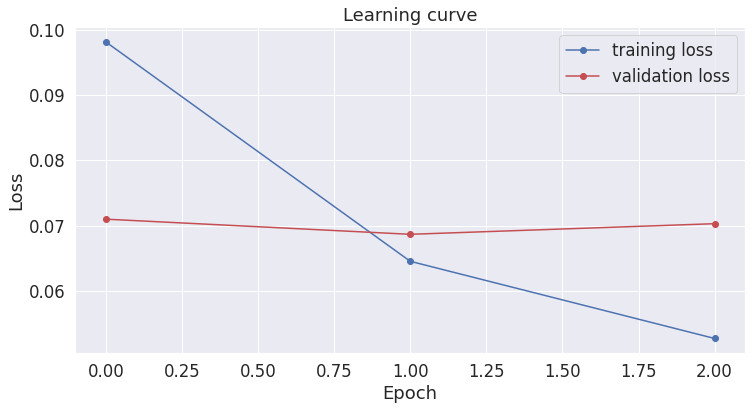

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [0]:
test_sentence = """
The most commonly reported side effect of methoxsalen alone is nausea, which occurs with approximately 10% of all patients. This effect may be minimized or avoided by instructing the patient to take methoxsalen with milk or food, or to divide the dose into two portions, taken approximately one-half hour apart. Other effects include nervousness, insomnia, and psychological depression.
"""

In [0]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [0]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [0]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [41]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	The
O	most
O	commonly
O	reported
O	side
O	effect
O	of
O	methoxsalen
O	alone
O	is
AdverseReaction	nausea
O	,
O	which
O	occurs
O	with
O	approximately
O	10
O	%
O	of
O	all
O	patients
O	.
O	This
O	effect
O	may
O	be
O	minimized
O	or
O	avoided
O	by
O	instructing
O	the
O	patient
O	to
O	take
O	methoxsalen
O	with
O	milk
O	or
O	food
O	,
O	or
O	to
O	divide
O	the
O	dose
O	into
O	two
O	portions
O	,
O	taken
O	approximately
O	one
O	-
O	half
O	hour
O	apart
O	.
O	Other
O	effects
O	include
AdverseReaction	nervousness
O	,
AdverseReaction	insomnia
O	,
O	and
AdverseReaction	psychological
AdverseReaction	depression
O	.
O	[SEP]


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# drive.mount('/content/drive')
# torch.save(model.state_dict(), '/content/drive')

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [63]:
print(os.getcwd())
print(os.listdir())

/content
['.config', 'unannotated_xml', 'drug_labels_unannotated_tokens.pkl', 'unannotated_xml.tar.gz', 'adc.json', 'train_xml', 'drug_labels_annotated.pkl', 'osfstorage-archive.zip', 'drive', 'drug_labels_annotated_tokens.pkl', 'test_labels.pkl', 'train_xml.tar.gz', 'test_labels', 'drug_labels_unannotated.pkl', 'sample_data']


In [66]:
torch.save(model.state_dict(), '/content/drive/My\ Drive/Bert_model')

FileNotFoundError: ignored

In [69]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [70]:
!ls

adc.json			    sample_data
drive				    test_labels
drug_labels_annotated.pkl	    test_labels.pkl
drug_labels_annotated_tokens.pkl    train_xml
drug_labels_unannotated.pkl	    train_xml.tar.gz
drug_labels_unannotated_tokens.pkl  unannotated_xml
osfstorage-archive.zip		    unannotated_xml.tar.gz


In [0]:
model_save_name = 'Bert.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)